<a href="https://colab.research.google.com/github/RysanDeluna/Q1DCA-experiments/blob/master/ExperimentsRule90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Rule 90 - experimentos iniciais

In [ ]:
# Get packages & Setup IBM account details
!pip install qiskit qiskit_aer qiskit_ibm_runtime numpy pandas  matplotlib pylatexenc

from qiskit_ibm_runtime import QiskitRuntimeService

my_token = "insert-token"
service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

In [4]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session

def simulate_noise(circuit, shots=1024):
    aersim_backend = AerSimulator.from_backend(service.get_backend("ibm_kyoto"))
    pm = generate_preset_pass_manager(backend=aersim_backend, optimization_level=1)
    isa_qc = pm.run(circuit)

    with Session(backend=aersim_backend) as session:
        sampler = Sampler(session=session)
        job = sampler.run([isa_qc], shots=shots)

    return job.result()

def simulate_ideal(circuit, shots=1024):
    aersim_backend = AerSimulator()
    pm = generate_preset_pass_manager(backend=aersim_backend, optimization_level=1)
    isa_qc = pm.run(circuit)

    with Session(backend=aersim_backend) as session:
        sampler = Sampler(session=session)
        job = sampler.run([isa_qc], shots=shots)

    return job.result()

def simulate_real(circuit, shots=1, back=""):
    if back == "":
        backend = service.least_busy(operational=True, simulator=False)
    else:
        backend = service.backend(back)

    # Convert the circuit so it can be ran in the specified backend
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    isa_circuit = pm.run(circuit)

    # Inicia o Sampler e roda o código
    sampler = Sampler(backend=backend)
    job = sampler.run([isa_circuit], shots=shots)
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    return job.result()

In [5]:
import qiskit

def prepare_rule90(qc: qiskit.QuantumCircuit):
    qc.h([0,1,2])

    # Middle bit
    qc.cx([0,2,3],[3,3,1])
    qc.barrier()
    qc.reset(3)

    # Left bit
    qc.cx([1,3],[3,2])
    qc.barrier()
    qc.reset(3)

    # Right bit
    qc.cx([1,3],[3,0])
    qc.barrier()
    qc.reset(3)

    qc.h([0,1,2])
    return qc

In [6]:
import pandas as pd

def show_data(result):
    return pd.DataFrame.from_dict(result[0].data.meas.get_counts(), orient="index", columns=['counts'])

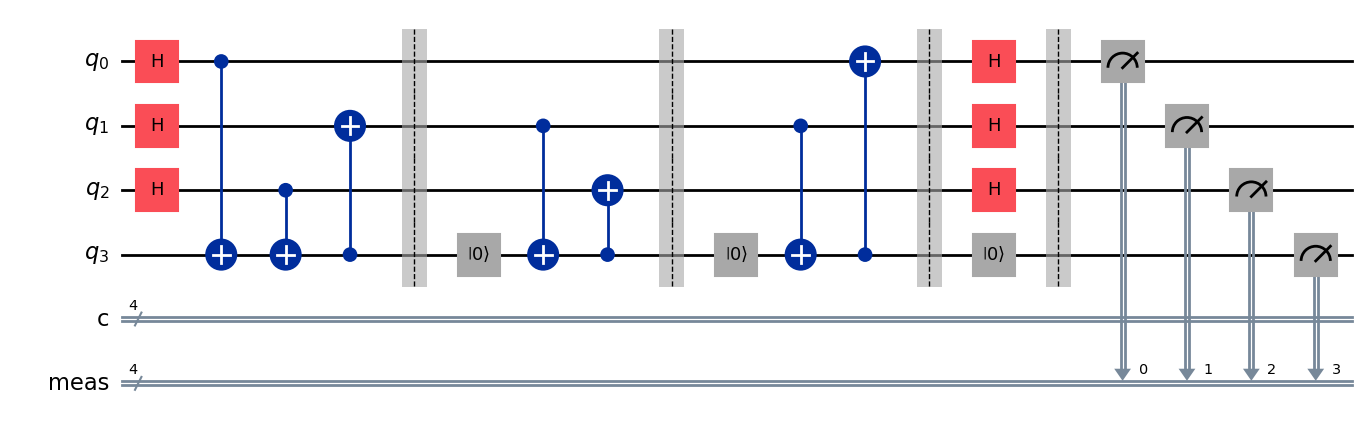

In [11]:
circuit = prepare_rule90(qiskit.QuantumCircuit(4,4))
circuit.measure_all()
circuit.draw('mpl')

In [ ]:
result_ideal = simulate_ideal(circuit, 5120)
result_noise = simulate_noise(circuit, 5120)

In [8]:
result_real = simulate_real(circuit, shots=5120)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 649.5556236231932 quantum seconds, but you only have 589 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


>>> Job ID: cs2dh4m965y000853csg
>>> Job Status: QUEUED


In [12]:
df_ideal = show_data(result_ideal)
df_noise = show_data(result_noise)
df_real = show_data(result_real)

df = pd.DataFrame(columns=['noise','real','ideal'], dtype='int32')
df[['noise']] = df_noise[['counts']]
df[['real']] = df_real[['counts']]
df[['ideal']] = df_ideal[['counts']]
df['ideal'].fillna(value=0, inplace=True)
df

,noise,real,ideal
0000,1177,726,1314.0
0101,1204,725,1358.0
0010,1158,739,1255.0
0111,1198,757,1193.0
0100,76,542,0.0
1010,7,4,0.0
0110,91,512,0.0
0001,88,528,0.0
0011,90,535,0.0
1111,10,6,0.0


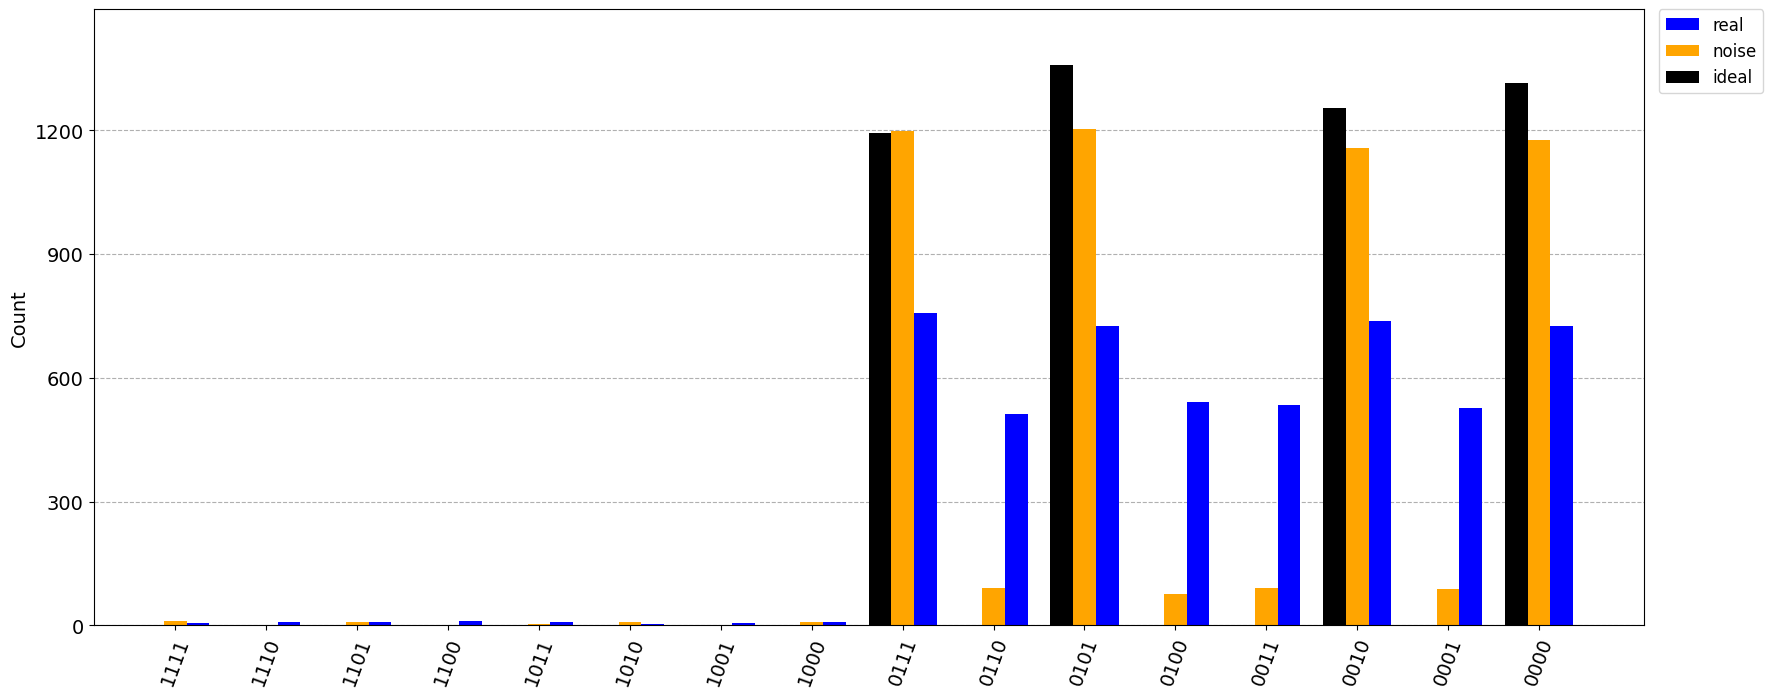

In [33]:
from qiskit.visualization import plot_histogram

count_real = result_real[0].data.meas.get_counts()
count_noise = result_noise[0].data.meas.get_counts()
count_ideal = result_ideal[0].data.meas.get_counts()

plot_histogram(
    [count_real, count_noise, count_ideal],
    legend=["real", "noise", "ideal"],
    sort="desc",
    figsize=(20, 8),
    color=["blue", "orange", "black"],
    bar_labels=False,
)
